In [ ]:
!pip install nbimporter

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torch.nn.init as init
from torch.autograd import Variable
from dataLoader import loadData

In [2]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# #     http://www.grouplens.org/system/files/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [3]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [4]:
seed = 47
np.random.seed(seed)

In [5]:
# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed, transpose=False, valfrac=0.1)

reading data...
data read in 4.8589160442352295 seconds
loaded dense data matrix


In [6]:
np.save('./tr_movielens_1m', tr)
np.save('./vr_movielens_1m', vr)

In [7]:
tr

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
vr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [10]:
get_sparsity(tr)

4.021525859265269

In [11]:
get_sparsity(vr)

0.44683670296601535

In [12]:
train = tr.copy()

In [13]:
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

# Training Denoising Autoencoder

In [14]:
############## Pytorch model doesn't converge - to do - check #################

from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1', kernel_regularizer=regularizers.l2(0.000001))(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(512, activation='selu', name='LatentSpace', kernel_regularizer=regularizers.l2(0.000001))(enc)
    lat_space = Dropout(0.5, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1', kernel_regularizer=regularizers.l2(0.000001))(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred', kernel_regularizer=regularizers.l2(0.000001))(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

Using TensorFlow backend.


In [15]:
zero_mask = (train == 0)
positive_feedback_mask = (train > 3)
negative_feedback_mask = ((train < 4) * (1 - zero_mask))

In [16]:
assert (positive_feedback_mask + negative_feedback_mask != zero_mask).all()
assert (positive_feedback_mask + negative_feedback_mask == 1 - zero_mask).all()

In [17]:
get_sparsity(zero_mask), get_sparsity(positive_feedback_mask), get_sparsity(negative_feedback_mask)

(95.97847414073473, 2.3124349989099473, 1.7090908603553212)

In [18]:
100 - get_sparsity(zero_mask), get_sparsity(positive_feedback_mask) + get_sparsity(negative_feedback_mask)

(4.021525859265267, 4.021525859265268)

In [19]:
P = 0.4
mask_arr_neg = (np.random.rand(negative_feedback_mask.shape[0], negative_feedback_mask.shape[1]) > P)
y_neg = negative_feedback_mask
X_neg = negative_feedback_mask*mask_arr_neg # corrupting 

In [20]:
mask_arr_pos = (np.random.rand(positive_feedback_mask.shape[0], positive_feedback_mask.shape[1]) > P)
y_pos = positive_feedback_mask
X_pos = positive_feedback_mask*mask_arr_pos # corrupting 

In [21]:
get_sparsity(X_neg), get_sparsity(y_neg), get_sparsity(X_pos), get_sparsity(y_pos)

(1.026195215919772, 1.7090908603553212, 1.3870741200058612, 2.3124349989099473)

In [22]:
model_neg = autoEncoder(X_neg)
model_neg.compile(optimizer = Adam(lr=0.0001), loss='mse')

model_pos = autoEncoder(X_pos)
model_pos.compile(optimizer = Adam(lr=0.0001), loss='mse')

In [23]:
model_neg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       (None, 3706)              0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               1897984   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               262656    
_________________________________________________________________
Dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               262656    
_________________________________________________________________
UserScorePred (Dense)        (None, 3706)              1901178   
Total params: 4,324,474
Trainable params: 4,324,474
Non-trainable params: 0
_________________________________________________

In [24]:
# predicted_tr = np.load('predicted_tr.npy')
# augmented_train = np.load('augmented_train.npy')

In [26]:
hist_neg = model_neg.fit(x=X_neg, y=y_neg,
                  epochs=300,
                  batch_size=128,
                  shuffle=True,predicted_tr = np.load('predicted_tr.npy')
# augmented_train = np.load('augmented_train.npy')
                  validation_split=0.0)

Epoch 1/300
6040/6040 [==============================] - ETA: 25s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 9s - loss: 0.0515 - ETA: 7s - loss: 0.051 - ETA: 6s - loss: 0.052 - ETA: 5s - loss: 0.051 - ETA: 5s - loss: 0.051 - ETA: 4s - loss: 0.051 - ETA: 4s - loss: 0.051 - ETA: 4s - loss: 0.050 - ETA: 3s - loss: 0.049 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.050 - ETA: 3s - loss: 0.049 - ETA: 3s - loss: 0.050 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.049 - ETA: 2s - loss: 0.048 - ETA: 1s - loss: 0.048 - ETA: 1s - loss: 0.048 - ETA: 1s - loss: 0.048 - ETA: 1s - loss: 0.048 - ETA: 1s - loss: 0.047 - ETA: 1s - loss: 0.047 - ETA: 1s - loss: 0.047 - ETA: 1s - loss: 0.047 - ETA: 1s - loss: 0.047 - ETA: 1s - loss: 0.046 - ETA: 0s - loss: 0.046 - ETA: 0s - loss: 0.046 - ETA: 0s - loss: 0.046 - ETA: 0s - loss: 0.046 - ETA: 0s - loss: 0.046 - ETA: 0

6040/6040 [==============================] - ETA: 3s - loss: 0.023 - ETA: 3s - loss: 0.022 - ETA: 3s - loss: 0.022 - ETA: 3s - loss: 0.021 - ETA: 3s - loss: 0.021 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.021 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.021 - ETA: 2s - loss: 0.021 - ETA: 2s - loss: 0.021 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.011 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.010 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.010 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.010 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.0

In [28]:
hist_pos = model_pos.fit(x=X_pos, y=y_pos,
                  epochs=300,
                  batch_size=128,
                  shuffle=True,
                  validation_split=0.0)

Epoch 1/300
6040/6040 [==============================] - ETA: 22s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 9s - loss: 0.0717 - ETA: 7s - loss: 0.070 - ETA: 6s - loss: 0.070 - ETA: 5s - loss: 0.070 - ETA: 5s - loss: 0.069 - ETA: 4s - loss: 0.068 - ETA: 4s - loss: 0.068 - ETA: 4s - loss: 0.068 - ETA: 3s - loss: 0.068 - ETA: 3s - loss: 0.067 - ETA: 3s - loss: 0.067 - ETA: 3s - loss: 0.066 - ETA: 3s - loss: 0.065 - ETA: 3s - loss: 0.065 - ETA: 2s - loss: 0.065 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.063 - ETA: 2s - loss: 0.063 - ETA: 2s - loss: 0.062 - ETA: 2s - loss: 0.063 - ETA: 2s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.062 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.061 - ETA: 1s - loss: 0.060 - ETA: 1s - loss: 0.060 - ETA: 1s - loss: 0.060 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 1s - loss: 0.059 - ETA: 0s - loss: 0.059 - ETA: 0s - loss: 0.059 - ETA: 0s - loss: 0.058 - ETA: 0s - loss: 0.058 - ETA: 0

6040/6040 [==============================] - ETA: 2s - loss: 0.025 - ETA: 3s - loss: 0.022 - ETA: 3s - loss: 0.023 - ETA: 2s - loss: 0.023 - ETA: 2s - loss: 0.023 - ETA: 2s - loss: 0.023 - ETA: 2s - loss: 0.023 - ETA: 2s - loss: 0.024 - ETA: 2s - loss: 0.023 - ETA: 2s - loss: 0.024 - ETA: 2s - loss: 0.024 - ETA: 2s - loss: 0.023 - ETA: 2s - loss: 0.024 - ETA: 2s - loss: 0.024 - ETA: 2s - loss: 0.024 - ETA: 2s - loss: 0.024 - ETA: 2s - loss: 0.024 - ETA: 2s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.020 - ETA: 3s - loss: 0.019 - ETA: 3s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.019 - ETA: 2s - loss: 0.019 - ETA: 2s - loss: 0.019 - ETA: 2s - loss: 0.019 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 1s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.019 - ETA: 2s - loss: 0.020 - ETA: 3s - loss: 0.020 - ETA: 3s - loss: 0.019 - ETA: 2s - loss: 0.019 - ETA: 2s - loss: 0.019 - ETA: 2s - loss: 0.019 - ETA: 2s - loss: 0.019 - ETA: 2s - loss: 0.019 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.019 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.017 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.015 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.016 - ETA: 3s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.015 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

6040/6040 [==============================] - ETA: 2s - loss: 0.012 - ETA: 3s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.0

In [29]:
import matplotlib.pyplot as plt 

def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

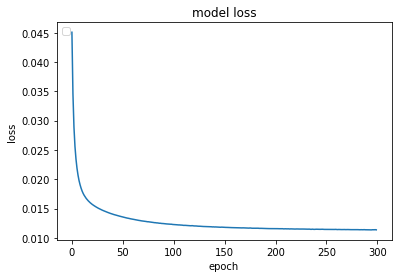

In [30]:
plot_hist(hist_neg)

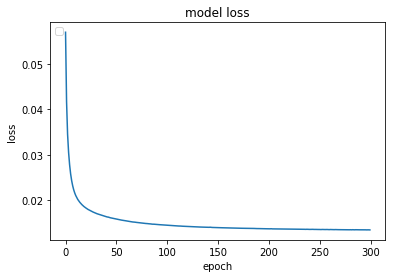

In [31]:
plot_hist(hist_pos)

In [32]:
model_neg.save('./model_neg')
model_pos.save('./model_pos')

In [36]:
np.set_printoptions(precision=3)
predicted_neg = model_neg.predict(X_neg)
predicted_pos = model_pos.predict(X_pos)

In [38]:
(predicted_neg > 0.4).sum(), (y_neg == 1).sum() # predicted vs real

(170143, 382567)

In [39]:
(predicted_neg>0.5).sum(), (predicted_pos>0.5).sum() # trained on

(115775, 214496)

In [41]:
print((y_neg * (predicted_neg>0.4)).sum()/(predicted_neg>0.4).sum()) # accuracy on actual 
print((y_pos * (predicted_pos>0.4)).sum()/(predicted_pos>0.4).sum())

0.9528337927508037
0.9187441580985445


In [43]:
print((y_pos * (predicted_neg>0.4)).sum()/(y_pos>0.4).sum()) # just to see that it's a low number
print((y_neg * (predicted_pos>0.4)).sum()/(y_neg>0.4).sum())

0.004936043939484681
0.016499070751005707


In [44]:
(y_neg * (predicted_neg>0.5)).sum()/((predicted_neg>0.5).sum())

0.9862405527963722

In [45]:
(y_pos * (predicted_pos>0.5)).sum()/((predicted_pos>0.5).sum())

0.9698642398925854

In [46]:
((predicted_neg>0.5)  * (X_neg<0.5)).sum() # predicted values which were not in the train matrix

39637

In [48]:
((predicted_pos>0.5)  * (X_pos<0.5)).sum() # predicted values which were not in the train matrix

69892

In [53]:
((y_neg * (((predicted_neg>0.5)  * (X_neg<0.5)))) == 1).sum()/(((predicted_neg>0.5)  * (X_neg<0.5))).sum()

0.9598102782753488

In [52]:
((y_pos * (((predicted_pos>0.5)  * (X_pos<0.5)))) == 1).sum()/(((predicted_pos>0.5)  * (X_pos<0.5))).sum()

0.9075144508670521

In [54]:
to_add_negative = model_neg.predict(y_neg)
to_add_positive = model_neg.predict(y_pos)

In [55]:
(to_add_negative>0.5).sum(), (to_add_positive>0.5).sum()

(207742, 234140)

In [58]:
(y_neg* (to_add_negative>0.8)).sum()/(((to_add_negative>0.8)).sum()), (y_pos* (to_add_positive>0.8)).sum()/(((to_add_positive>0.8)).sum())

(0.9874735206891682, 0.9078462031914041)

In [70]:
# to keep the balance
threshold_neg = 0.25
threshold_pos = 0.4 

In [71]:
((to_add_negative > threshold_neg) * (tr==0)).sum(), ((to_add_positive > threshold_pos) * (tr==0)).sum() # new values # new values

(202887, 101849)

In [72]:
p_probs_neg = [(tr == 1).sum()/((tr > 0) & (tr < 4)).sum(), (tr == 2).sum()/(((tr > 0) & (tr < 4))).sum(), (tr == 3).sum()/((tr > 0) & (tr < 4)).sum()]
p_probs_neg

[0.13207882540835983, 0.25313474502505445, 0.6147864295665857]

In [79]:
p_probs_pos = [(tr == 4).sum()/((tr > 3) & (tr <= 5)).sum(), (tr == 5).sum()/((tr > 3) & (tr <= 5)).sum()]
p_probs_pos

[0.6064147320143503, 0.39358526798564974]

In [83]:
augmented_train = tr + (to_add_negative > threshold_neg) * (tr == 0) * np.random.choice(np.arange(1, 4), tr.shape, p=p_probs_neg) + (to_add_positive > threshold_pos) * (tr == 0) * np.random.choice(np.arange(4, 6), tr.shape, p=p_probs_pos)

In [84]:
get_sparsity(tr), get_sparsity(augmented_train)

(4.021525859265269, 5.309490069799109)

In [85]:
(np.isin(tr, augmented_train)).all()

True

In [86]:
print(5, (5 == tr).sum())
print(4, (4 == tr).sum())
print(3, (3 == tr).sum())
print(2, (2 == tr).sum())
print(1, (1 == tr).sum())
print(0, (0 == tr).sum())

5 203728
4 313893
3 235197
2 96841
1 50529
0 21484052


In [87]:
print(5, (5 == augmented_train).sum())
print(4, (4 == augmented_train).sum())
print(3, (3 == augmented_train).sum())
print(2, (2 == augmented_train).sum())
print(1, (1 == augmented_train).sum())
print(0, (0 == augmented_train).sum())

5 238718
4 365615
3 349697
2 144258
1 75064
0 21195751


In [88]:
((tr == 0) * (augmented_train > 0)).sum() # new values

288301

In [89]:
# np.save('predicted_tr', predicted_tr)
np.save('augmented_train', augmented_train)

In [90]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, use_cuda=True):
        super(NetD, self).__init__()
        self.use_cuda = use_cuda
        # top
        self.t1 = torch.nn.Linear(features_length, 1024)
        # bottom
        self.b1 = torch.nn.Linear(features_length, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, features_length)
    def forward(self, xr, xf):
        # get filt
#         filt = (torch.abs((real > 0.3).float() * fake - real))/real.shape[0]
#         filt = torch.abs((xr != 0).float().cuda() * xf.cuda() - xr.cuda())/xr.shape[0]
#         filt = torch.abs(xf - xr)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
#         filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())

#         filt = torch.abs((xr != 0).int() * xf - xr)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
        if self.use_cuda: 
            idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
#         print(filt.type(), x.type())
#         x = filt * x

        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        if self.use_cuda: 
            sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
#         print(x.shape, xr.shape, xf.shape, d_my(xr, xf))
#         print(x)
#         print(xr)
#         print(xf)
#         print (x)
#         print(d_my(xr, xf))
#         print(x * (x <= d_my(xr, xf)).float() + d_my(xr, xf) * (x > d_my(xr, xf)).float())
#         if x > d_my(xr, xf):
#             x = d_my(xr, xf)
        x = x * (x <= d_my(xr, xf)).float() + d_my(xr, xf) * (x > d_my(xr, xf)).float()
        return x
        
# netG = torch.nn.Sequential(
#     torch.nn.Linear(nz, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, features_length),
#     torch.nn.Sigmoid()*5
#     )

class NetG(nn.Module):
    
    def __init__(self):

        super(NetG, self).__init__()

        self.netGen = torch.nn.Sequential( 
                                torch.nn.Linear(nz, 1024), 
#                                 torch.nn.BatchNorm1d(1024),
                                torch.nn.ReLU(), 
#                                 nn.Dropout(0.5),
                                torch.nn.Linear(1024, 1024),
#                                 torch.nn.BatchNorm1d(1024),
                                torch.nn.ReLU(), 
#                                 nn.Dropout(0.6),
                                torch.nn.Linear(1024, features_length), 
#                                 torch.nn.BatchNorm1d(features_length),
#                                 nn.Dropout(0.7),
#                                 torch.nn.Sigmoid()
                                )

#         self.net = nn.Sequential(
#                                  nn.Linear(nz,1024),
# #                                  nn.Dropout(0.3)
#                                  nn.ReLU(),
#                                  nn.Linear(1024,2048),
#                                  nn.Sigmoid(),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(2048,features_length),
# #                                  nn.Sigmoid()
#                                  nn.Dropout(0.5)
#                                     )
        
    def forward(self, x):
        x = self.netGen(x)
        return x
#         return F.dropout(x, 0.7)
#         return 5 * self.netGen(x)
#         return torch.sigmoid(x) 
#         return x*5 # to get values in range [0,5]

In [91]:
def get_random_batch(mat, batch_size=64):
    '''
    returns random rows of size batch_size
    '''
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]

In [92]:
train = torch.autograd.Variable(torch.Tensor(train))
augmented_train = torch.autograd.Variable(torch.Tensor(augmented_train))

In [93]:
get_sparsity(train.cpu().numpy()), get_sparsity(augmented_train.cpu().numpy())

(4.021525859265269, 5.309490069799109)

In [ ]:
# xx = get_random_batch(train)
# xy = get_random_batch(train)

In [ ]:
# d_my(xx, xy)

In [ ]:
# torch.sum(torch.abs(torch.abs(xx != 0).float()*xy - xy), 1)

In [ ]:
# xx > xy

In [ ]:
# def d_my(x_r, x_g): # custom loss -todo
#     return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r), 1)/x_r.shape[1]

def d_my(x_r, x_g): # custom loss -todo
    return torch.sum(torch.abs(x_g - x_r), 1)/x_r.shape[1]

In [ ]:
def train_GAN(netD, netG, train_mat, steps_per_epoch = 300, epochs = 300):
    gen_iterations = 0
    eval_losses = []
    d_iter = 5
    g_iter = 1
    for epoch in range(epochs):
        i = 0
        while i < steps_per_epoch:
            ############################
            # (1) Update D network
            ###########################
            for p in netD.parameters(): # reset requires_grad
                p.requires_grad = True # they are set to False below in netG update
            d_iter = d_iter
            j = 0
            while j < d_iter*5:
                j += 1
                # load real data
                i += 1
    #             X, _ = data_iter.next()
                X = get_random_batch(train, batch_size=batch_size).to(device)
    #             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
    #             print(X >= 0.5)
    # #             X = X.view(X.size(0), -1)
    #             X = (X >= 0.5).float()
#                 if cuda: 
#                     X = X.cuda()
#                 real = Variable(X)
#                 real = X.clone()
#                 real = X + fake * (X == 0).float()
                # generate fake data
                noise = torch.randn(batch_size, nz).to(device)
#                 if cuda: 
#                     noise = noise.cuda()
                with torch.no_grad():
                    noisev = Variable(noise) # totally freeze netG
                    
#                 fake = netG(noisev).to(device)
                fake = Variable(netG(noisev).data).to(device)
#                 fake.requires_grad = False
    #             print(real[0,:20], fake[0,:20])
#                 real + fake * (real == 0).float()
#                 fake = fake * Variable(real != 0).float().cuda()

    #             real + fake * (real == 0).float()
    #             print(real[0,:20], fake[0,:20])
#                 fake.requires_grad = False
    #             print(real.shape, fake.shape)

                # compute gradient, take step
                netD.zero_grad()
    #             print('real', real[:10, :20])
    #             print('fake', fake[:10, :20])
    #             print(real.type(), fake.type())
    #             print(fake)
#                 print(real)
#                 real = X + fake * (X == 0).float()
#                 print(real[0])
#                 print(fake[0])
                real = Variable(X)
                out = netD(real, fake)

                outputD = torch.mean(out) + lamba * out.norm()
                stdD = torch.std(out)
                outputD.backward(mone)
                optimizerD.step()
    #             print(out.shape)
            ############################
            # (2) Update G network
            ###########################
            g_iter = g_iter
            j = 0
            while j < g_iter:
                j += 1
                for p in netD.parameters():
                    p.requires_grad = False # to avoid computation
#                 for p in netG.parameters():
#                     p.requires_grad = True # to avoid computation
                    
                netG.zero_grad()

                # load real data
                i += 1
                X = get_random_batch(train, batch_size=batch_size).to(device)
    #             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
    #             X = X.view(X.size(0), -1)
    #             X = (X >= 0.5).float()
#                 if cuda: 
#                     X = X.cuda()
#                 real = Variable(X)
#                 real = X.clone()

                # update generator
                noise = torch.randn(batch_size, nz).to(device)
#                 if cuda: 
#                     noise = noise.cuda()
                fake = netG(noisev).to(device)
#                 noisev = Variable(noise)

#                 fake = Variable(netG(noisev).data)

#                 real = real + fake * (real == 0).float()
#                 fake = fake * Variable(real != 0).float().cuda()
                
    #             fake = fake * Variable(real != 0).float().cuda()
#                 fake.requires_grad = False
    #             fake = Variable(netG(noisev)).data
    #             fake = fake * Variable(((real != 0) & (fake > 0.8))).float().cuda()
    
#                 fake.requires_grad = True
#                 real = X + fake * (X == 0).float()
                real = Variable(X)
                out = netD(real, fake)
                outputG = torch.mean(out) + lamba * out.norm()
                stdG = torch.std(out)
#                 print(real.requires_grad, fake.requires_grad)
                outputG.backward(one)
                optimizerG.step()

                gen_iterations += 1

    #             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, len(data_loader), gen_iterations, outputD.item(), outputG.item()))
    #             print('output_D', outputD.item(), gen_iterations)
    #             print('output_G', outputG.item(), gen_iterations)
    #             print('std_D', stdD.item(), gen_iterations)
    #             print('std_G', stdG.item(), gen_iterations)

                # evaluation
                if gen_iterations % 100 == 0: # todo- to change
    #                 gen.eval()
    #                 z_vector_eval = make_some_noise(128)
    #                 fake_rows_eval = gen(z_vector_eval)
    #                 real_rows_eval = get_random_batch(train, 128)
            #         print(fake_rows[0][:10]) enable to see some results
    #                 fake = Variable(netG(noisev).data).round()
    #                 fake = ((real != 0) & (fake != 0))
    #                 print(fake)
                    eval_loss = F.mse_loss(fake, real, reduction='mean')
                    eval_losses.append(eval_loss)
                    print("######"*40)
                    print('Epoch number {}. my distance between random real and fake samples sum {}'.format(epoch, d_my(real, fake).sum()))
                    print('Epoch number {}. my distance between random real and fake samples {}'.format(epoch, d_my(real, fake).mean()))
                    print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))
                    print("######"*40)
                    
    return eval_losses

In [ ]:
lrD = 5e-4
lrG = 5e-4
batch_size = 128
cuda = True
epochs = 1000 #change
seed = 1
nz = 16
d_iter = 5
g_iter = 1
lamba = 2e-4

In [ ]:
# networks
netD_tr = NetD().to(device)
netG_tr = NetG().to(device)
print(netD_tr)
print(netG_tr)
optimizerG = optim.RMSprop(netG_tr.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD_tr.parameters(), lr=lrD)
one = torch.FloatTensor([1]).to(device)
mone = (-1 * one).to(device)

In [ ]:
eval_losses_tr = train_GAN(netD_tr, netG_tr, train)

In [ ]:
torch.save(netG_augm.state_dict(), './netG_augm-1m')
torch.save(netD_augm.state_dict(), './netD_augm-1m')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eval_losses_tr)
plt.show()

In [ ]:
netG_tr.eval()

In [ ]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG_tr(noisev)

In [ ]:
fake.shape

In [ ]:
fake = np.around(fake.detach().cpu().numpy())

In [ ]:
np.unique(fake)

In [ ]:
fake = fake * (fake <= 5).astype(int)

In [ ]:
np.unique(fake)

In [ ]:
get_sparsity(fake)

In [ ]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

As we see there is a significant bias towards higher ratings

In [ ]:
# networks
netD_augm = NetD().to(device)
netG_augm = NetG().to(device)
print(netD_augm)
print(netG_augm)
optimizerG = optim.RMSprop(netG_augm.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD_augm.parameters(), lr=lrD)
one = torch.FloatTensor([1]).to(device)
mone = (-1 * one).to(device)

In [ ]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG_augm(noisev)

In [ ]:
fake = np.around(fake.detach().cpu().numpy())
np.unique(fake)

In [ ]:
# without train
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

In [ ]:
# netD_augm.load_state_dict(torch.load('./netG_augm-1m'))
# netD_augm.load_state_dict(torch.load('./netD_augm-1m'))

In [ ]:
eval_losses_aug = train_GAN(netD_augm, netG_augm, augmented_train)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eval_losses_aug)
plt.show()

In [ ]:
# netG_tr.eval()
netG_augm.eval()

In [ ]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG_augm(noisev)

In [ ]:
fake = np.around(fake.detach().cpu().numpy())

In [ ]:
np.unique(fake)

In [ ]:
# fake = fake * (fake <= 5).astype(int)

fake = fake.clip(0,5)

In [ ]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

In [ ]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)

fake_tr = netG_tr(noisev)
fake_aug = netG_augm(noisev)

In [ ]:
torch.unique(fake_tr.round()), torch.unique(fake_aug.round())

In [ ]:
fake_tr = fake_tr.clamp(0,5).detach().cpu().numpy().round()
fake_aug = fake_aug.clamp(0,5).detach().cpu().numpy().round()

In [ ]:
print(5, (5 == fake_tr).sum(), (5 == (tr + vr)[:fake.shape[0], :]).sum())
print(4, (4 == fake_tr).sum(), (4 == (tr + vr)[:fake.shape[0], :]).sum())
print(3, (3 == fake_tr).sum(), (3 == (tr + vr)[:fake.shape[0], :]).sum())
print(2, (2 == fake_tr).sum(), (2 == (tr + vr)[:fake.shape[0], :]).sum())
print(1, (1 == fake_tr).sum(), (1 == (tr + vr)[:fake.shape[0], :]).sum())
print(0, (0 == fake_tr).sum(), (0 == (tr + vr)[:fake.shape[0], :]).sum())

In [ ]:
print(5, (5 == fake_aug).sum(), (5 == (tr + vr)[:fake.shape[0], :]).sum())
print(4, (4 == fake_aug).sum(), (4 == (tr + vr)[:fake.shape[0], :]).sum())
print(3, (3 == fake_aug).sum(), (3 == (tr + vr)[:fake.shape[0], :]).sum())
print(2, (2 == fake_aug).sum(), (2 == (tr + vr)[:fake.shape[0], :]).sum())
print(1, (1 == fake_aug).sum(), (1 == (tr + vr)[:fake.shape[0], :]).sum())
print(0, (0 == fake_aug).sum(), (0 == (tr + vr)[:fake.shape[0], :]).sum())

In [ ]:
get_sparsity(tr), get_sparsity(fake_tr), get_sparsity(fake_aug)

In [ ]:
# tr_orig, vr_1 = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed,  transpose=False, valfrac=0.1)

In [94]:
import nbimporter 
import matrix_factorization

Importing Jupyter notebook from matrix_factorization.ipynb


In [ ]:
rand_ix = np.random.randint(0, fake.shape[0], 300)

In [ ]:
# adding_fake_autoenc = fake_tr[rand_ix,:]
adding_fake_autoenc_lus_gan = fake_aug[rand_ix,:]

In [ ]:
np.unique(fake_aug)

In [ ]:
np.unique(adding_fake_autoenc_lus_gan[0,:])

In [ ]:
(adding_fake_autoenc == 1).sum()

In [ ]:
(adding_fake_autoenc_lus_gan == 1).sum()

In [ ]:
np.unique(adding_fake_autoenc_lus_gan[0,:])

In [ ]:
adding_fake[0,0:200]

In [ ]:
adding_fake_autoenc_lus_gan[0,0:200]

In [ ]:
tr_auto_enc = np.append(tr, adding_fake_autoenc, axis=0)
tr_auto_enc_plus_gan = np.append(tr, adding_fake_autoenc_lus_gan, axis=0)

In [ ]:
iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
get_sparsity(augmented_train.cpu().numpy())

In [ ]:
# iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(augmented_train.cpu().numpy(), 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
# iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([50], vr, learning_rate=0.001)

In [ ]:
# iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(augmented_train.cpu().numpy(), 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([50], vr, learning_rate=0.001)

In [ ]:
tr.shape, augmented_train.cpu().numpy().shape, tr_auto_enc.shape, tr_auto_enc_plus_gan.shape

In [ ]:
get_sparsity(tr_auto_enc), get_sparsity(tr_auto_enc_plus_gan)

In [ ]:
# iter_array = [1, 2, 5, 10, 25, 40]

MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
# iter_array = [1, 2, 5, 10, 25, 40]

MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc_plus_gan, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
get_sparsity(tr_auto_enc_plus_gan), tr_auto_enc_plus_gan.shape

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc_plus_gan, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc_plus_gan, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(fake_aug, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [95]:
augmented_tr = augmented_train.cpu().numpy()

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(augmented_tr, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 1
